# Neural Prosthesis - Homework 1 
*Author : Johan Medrano - ID 0645241*

## 1. Influence of an input noise on the firing rate of a neuron 

For the following part, we will work with the [Python module interfacing NEURON](https://neuron.yale.edu/neuron/static/docs/neuronpython/).

In [1]:
from neuron import h, gui

import numpy as np
from matplotlib import pyplot as plt
import scipy.fftpack as scfft

We firstly create a soma, containing a Hodgkin-Huxley model. This model implements sodium, potassium and leakage channels.  

In [2]:
soma = h.Section(name='soma')
soma.insert('hh')
segment = soma(0.5)

Then, we configure the model, using the values given by Hodgkin and Huxley in they [original paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1392413/pdf/jphysiol01442-0106.pdf) "A quantitative description of membrane current and its application to conduction and excitation in nerve" (1952).We let the values of axial resistance and diameter of the soma as default. 

- $\bar{g_{Na}} =120\ mS/cm^2$
- $\bar{g_K} = 36\ mS/cm^2$
- $\bar{g_L} = 0.3\ mS/cm^2$
- $E_{Na} = -115\ mV$
- $E_K = 12\ mV$
- $E_L = -10.613\ mV$ 
$$$$


In [3]:
hh_model = segment.hh

soma.L = 18.8
segment.diam = 18.8
soma.Ra = 123.0

h.psection()

soma { nseg=1  L=18.8  Ra=123
	/*location 0 attached to cell 0*/
	/* First segment only */
	insert morphology { diam=18.8}
	insert capacitance { cm=1}
	insert hh { gnabar_hh=0.12 gkbar_hh=0.036 gl_hh=0.0003 el_hh=-54.3}
	insert na_ion { ena=50}
	insert k_ion { ek=-77}
}


1.0

Now our model is ready to be stimulated. We create a function doing the following : 
* creation a current stimulation, which is a clamp starting after a short delay (to let the model rush a equilibrium point), with a user-defined duration and amplitude, 
* creation of vector to record the inner potential of the soma during time,
* one run of the simulation, stopping when the clamp is over. 

We then create another function, doing the same thing but for with a noisy signal. 

In [4]:
def current_stim_run_once(stim_amplitude, stim_delay=25, stim_duration=500):
    global stim
    
    v_vec = h.Vector() 
    t_vec = h.Vector() 
    
    stim.delay = stim_delay
    stim.dur = stim_duration
    stim.amp = stim_amplitude

    v_vec.record(soma(0.5)._ref_v)
    t_vec.record(h._ref_t)

    h.tstop = stim.delay+stim.dur
    h.run()
    
    vv = h.Vector(len(v_vec))
    vv.copy(v_vec)
    v_vec = h.Vector()
    
    return vv, t_vec

def noisy_current_stim_run_once(clamp_amp, t_vec_noise, noise_var, clamp_delay):
    i_clean = np.array([0 if t_vec_noise[i] < clamp_delay else clamp_amp for i in range(len(t_vec_noise))])

    # 2000Hz noise max
    noise = np.random.normal(0., noise_var, 500) 
    
    
    noise = scfft.ifft(scfft.rfft(noise), len(t_vec_noise)) 
    noise *= noise_var / np.max(np.abs(noise)) 
    
    i_noisy = h.Vector(i_clean + noise)

    stim.delay=  0
    stim.dur = 1e9
    stim.amp = 0 
    i_noisy.play(stim._ref_amp, t_vec_noise)

    v_vec_noise = h.Vector() 
    
    v_vec_noise.record(soma(0.5)._ref_v)
    
    
    h.tstop = t_vec_noise[-1]
    h.run() 
    
    
    vv = h.Vector(len(v_vec_noise))
    vv.copy(v_vec_noise)
    v_vec_noise = h.Vector()
    
    return vv, i_noisy

In [5]:
def make_clamps(clamp_amp, clamp_delay, clamp_duration, time_res, noise_var=[]): 
    t_vec = np.linspace(0., clamp_delay+clamp_duration, time_res)
    
    clean_clamp = np.array([0 if t_vec[i] < clamp_delay else clamp_amp for i in range(time_res)])
    clamps = [clean_clamp]
        
    for nv in noise_var:
        # 2000Hz noise max
        noise = np.random.normal(0., 1, 500) 
        noise = scfft.ifft(scfft.rfft(noise), time_res) 
        noise *= nv / np.max(np.abs(noise)) 
        clamps.append(noise + clean_clamp)
    
    return h.Vector(t_vec), [h.Vector(cl) for cl in clamps]

In [6]:
def sim_clamp(clamp, t_vec): 
    global soma 
    
    if not isinstance(clamp, list): 
        _clamp = [clamp]
    else: 
        _clamp = clamp
    
    v_vec = []
    
    for c in _clamp: 
        vv = h.Vector()
        vv.record(soma(0.5)._ref_v)
        
        stim = h.IClamp(soma(0.5))
        stim.delay = 0
        stim.dur = 1e9
        
        c.play(stim._ref_amp, t_vec)
        
        h.run()
        
        v_vec.append(h.Vector())
        v_vec[-1].copy(vv)
        
    if not isinstance(clamp, list): 
        v_vec = v_vec[0]
    return v_vec

We then create a function detecting spikes on a time serie of voltages, counting a spike each time the first-order derivative of the voltage, $\frac{dV_{ref}}{dt}$, reaches a defined threshold. 

In [7]:
def get_spikes_count(v_vec, t_vec, thresh=10): 
    #dt_vec = [(t_vec[i] + t_vec[i+1])/2 for i in range(len(t_vec) - 1)]
    dv_vec = [(v_vec[i+1]-v_vec[i])/(t_vec[i+1]-t_vec[i]) for i in range(len(t_vec) - 1)]
    #plt.plot(dt_vec, dv_vec)
    #plt.show()
    spikes_count = np.sum([dv_vec[i]>thresh and dv_vec[i+1]<thresh for i in range(len(dv_vec) - 1)])
    
    return spikes_count

In [ ]:
min_current = 0
max_current =0.4
resolution = 50

stim_delay = 15
stim_duration = 100

time_res = 12001

input_current = []
spikes_count = {'clean':[], 'noisy':{'.05nA':[], '.1nA':[]}}
spikes_to_hertz = lambda x : (x / (stim_duration * 1e-3))
once = False
for curr in np.linspace(min_current, max_current, resolution): 
    t_vec, clamps = make_clamps(curr, stim_delay, stim_duration, time_res, [0.05,0.1])
    input_current.append(curr)
    #stim = h.IClamp(soma(0))
   # v_vec = sim_clamp(clamps, t_vec)
    
  #  t=  h.Vector() 
   # t.record(h._ref_t)
    if not once:
        v_vec_clean, t_vec_clean = current_stim_run_once(curr, stim_delay, stim_duration)
        #once = True
        t_vec = t_vec_clean
    #t_vec_noise = np.linspace(t_vec_clean[0], t_vec_clean[-1], noise_res)
    v_vec_noisy_1, clamp_1 = noisy_current_stim_run_once(curr, t_vec_clean, .05, stim_delay)
    v_vec_noisy_2, clamp_2 = noisy_current_stim_run_once(curr, t_vec_clean, .1, stim_delay)
        
    spikes_count['clean'].append(spikes_to_hertz(get_spikes_count(v_vec_clean, t_vec)))
    spikes_count['noisy']['.05nA'].append(spikes_to_hertz(get_spikes_count(v_vec_noisy_1, t_vec)))
    spikes_count['noisy']['.1nA'].append(spikes_to_hertz(get_spikes_count(v_vec_noisy_2, t_vec)))
print("-Done-")

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:33: ComplexWarning: Casting complex values to real discards the imaginary part


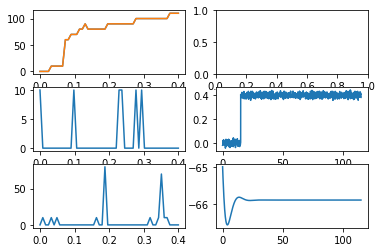

In [10]:
plt.subplot(3,2,1)
plt.plot(input_current, spikes_count['clean'])
plt.subplot(3,2,2)
#plt.plot(t_vec, clamps[0])
#plt.plot(np.linspace(0, t_vec[-1], len(v_vec[0])), v_vec[0])
plt.subplot(3,2,3) 
plt.plot(input_current, spikes_count['noisy']['.05nA'])
plt.subplot(3,2,4)
plt.plot(t_vec, clamp_1)
plt.subplot(3,2,5)
plt.plot(input_current, spikes_count['noisy']['.1nA'])
plt.subplot(3,2,6)
plt.plot(t_vec, v_vec_noisy_2)

plt.show()

In [ ]:
from scipy import interpolate as i 
N = 10000
L = 2000

noise0 = np.random.normal(0., 0.5, L) 
noise = scfft.ifft(scfft.rfft(noise0), N)
T = 1
df = 1 / T


f = scfft.fft(noise)
fre = scfft.fftfreq(N)
fre2 = scfft.fftfreq(L)

fre = [df * n for n in range(N)]
fre2 = [df * l for l in range(L)]

plt.plot(fre, f) 
plt.plot(fre2, scfft.rfft(noise0))
plt.show()
noise = scfft.ifft(scfft.fftfreq(N), len(t_vec_noise)) 
noise *= noise_var / np.max(np.abs(noise)) 
  


In [ ]:
print(300 / h.dt )